<a href="https://colab.research.google.com/github/jecampagne/cours_mallat_cdf/blob/main/cours2025/JAX_FLAX_NNX_UniversalDen_MNIST_jaxjit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sample generation using an universal denoiser

In the notebook `JAX_FLAX_NNX_blog_yang_song.ipynb` it is used a diffusion model developed by Y. Sonfg et al. whdere the
denoiser in conditionned by the std of the noise injected.

Z. Kadkhodaie &  E. P. Simoncelli [1] heve developped a generator algorithm based on an *universal denoiser* and Z. Kadkhodaie et al. [2] have studied the properties of such denoiser.

In this note book you will play the game with the MNIST dataset. You will see that the training can go well and sampling too even if can be a bit long (for the training). After, you can ask yourself if the generator is doing memerysation or generalisation? This is the subject of the article [2].


[1]: [Solving Linear Inverse Problems Using the Prior Implicit in a Denoiser (NeurIPS 2020)](https://openreview.net/forum?id=RLN7K4U3UST)

[2]: [Generalization in diffusion models arises from geometry-adaptive harmonic representations (ICLR 2024)](https://openreview.net/pdf?id=ANvmVS2Yr0)

In [4]:
%pip install -Uq jax[cuda12]  # at least see if you have 0.5.x

In [5]:
%pip install -Uq orbax-checkpoint  # 0.11.6

In [11]:
import jax
import flax
import orbax.checkpoint as ocp

num_devices = jax.device_count()

In [12]:
print(jax.__version__, flax.__version__, ocp.__version__)

0.5.1 0.10.3 0.11.6


In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 16

In [14]:
from torchvision import datasets, transforms
import os

In [15]:
import torch

In [16]:
import jax.numpy as jnp
from functools import partial
import numpy as np

In [17]:
args = {
    'seed': 2025,
}

# Set the parallel batch size.
args['batch_size'] = 256
args['epochs'] = 150
args['sigma_max'] = 1.0

In [18]:
import optax

from flax import nnx

from typing import Any, Callable, Sequence, Optional, Tuple
PRNGKey = jnp.ndarray


# Denoiser model

A type of U-Net model where I've follow in fact the one developped by Y. Song for its MNIST demo.

In [19]:
class Denoiser(nnx.Module):
  channels: Tuple[int] = (32, 64, 128, 256)

  def __init__(self, rngs: nnx.Rngs, din:int=1):
    self.act = nnx.swish

    self.conv1 = nnx.Conv(din, self.channels[0], (3, 3), (1, 1), padding='VALID',
                   use_bias=False, rngs=rngs)
    self.Norm1   = nnx.GroupNorm(self.channels[0],num_groups=4, use_bias=False, rngs=rngs)
    self.conv2 = nnx.Conv(self.channels[0], self.channels[1], (3, 3), (2, 2), padding='VALID',
                   use_bias=False, rngs=rngs)
    self.Norm2   = nnx.GroupNorm(self.channels[1], use_bias=False,rngs=rngs) # num_groups=32 by default
    self.conv3 = nnx.Conv(self.channels[1],self.channels[2], (3, 3), (2, 2), padding='VALID',
                   use_bias=False, rngs=rngs)
    self.Norm3   = nnx.GroupNorm(self.channels[2], use_bias=False,rngs=rngs)
    self.conv4 = nnx.Conv(self.channels[2], self.channels[3], (3, 3), (2, 2), padding='VALID',
                   use_bias=False, rngs=rngs)
    self.Norm4   = nnx.GroupNorm(self.channels[3], use_bias=False,rngs=rngs)

    #decoder
    self.conv5 = nnx.Conv(self.channels[3], self.channels[2], (3, 3), (1, 1), padding=((2, 2), (2, 2)),
                  input_dilation=(2, 2), use_bias=False, rngs=rngs)
    self.Norm5   = nnx.GroupNorm(self.channels[2], use_bias=False,rngs=rngs)
    self.conv6 = nnx.Conv(2*self.channels[2], self.channels[1], (3, 3), (1, 1), padding=((2, 3), (2, 3)),
                  input_dilation=(2, 2), use_bias=False, rngs=rngs)
    self.Norm6   = nnx.GroupNorm(self.channels[1], use_bias=False,rngs=rngs)

    self.conv7 = nnx.Conv(2*self.channels[1], self.channels[0], (3, 3), (1, 1), padding=((2, 3), (2, 3)),
                  input_dilation=(2, 2), use_bias=False, rngs=rngs)
    self.Norm7   = nnx.GroupNorm(self.channels[0], use_bias=False,rngs=rngs)

    self.conv8  = nnx.Conv(2*self.channels[0], din, (3, 3), (1, 1), padding=((2, 2), (2, 2)), rngs=rngs)

  def __call__(self, x):
    h1 = self.conv1(x)
    h1 = self.Norm1(h1)
    h1 = self.act(h1)

    h2 = self.conv2(h1)
    h2 = self.Norm2(h2)
    h2 = self.act(h2)

    h3 = self.conv3(h2)
    h3 = self.Norm3(h3)
    h3 = self.act(h3)

    h4 = self.conv4(h3)
    h4 = self.Norm4(h4)
    h4 = self.act(h4)

    # decondig
    h = self.conv5(h4)
    h = self.Norm5(h)
    h = self.act(h)

    h = self.conv6(jnp.concatenate([h, h3], axis=-1))
    h = self.Norm6(h)
    h = self.act(h)

    h = self.conv7(jnp.concatenate([h, h2], axis=-1))
    h = self.Norm7(h)
    h = self.act(h)

    h = self.conv8(jnp.concatenate([h, h1], axis=-1))

    return h

In [20]:
model = Denoiser(rngs=nnx.Rngs(0))

In [21]:
print(nnx.tabulate(model,jnp.ones((1,28,28,1))))

                                        Denoiser Summary                                         
┏━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path  ┃ type      ┃ inputs               ┃ outputs             ┃ Param                        ┃
┡━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       │ Denoiser  │ float32[1,28,28,1]   │ float32[1,28,28,1]  │ 867,873 (3.5 MB)             │
├───────┼───────────┼──────────────────────┼─────────────────────┼──────────────────────────────┤
│ conv1 │ Conv      │ float32[1,28,28,1]   │ float32[1,26,26,32] │ kernel: float32[3,3,1,32]    │
│       │           │                      │                     │                              │
│       │           │                      │                     │ 288 (1.2 KB)                 │
├───────┼───────────┼──────────────────────┼─────────────────────┼──────────────────────────────┤
│ Norm1 │ GroupNorm │ float32[1,26,26,32]  │ float32[1,26,26,32] │ scale: float32[32]           │
│       │           │                      │                     │                              │
│       │           │                      │                     │ 32 (128 B)                   │
├───────┼───────────┼──────────────────────┼─────────────────────┼──────────────────────────────┤
│ conv2 │ Conv      │ float32[1,26,26,32]  │ float32[1,12,12,64] │ kernel: float32[3,3,32,64]   │
│       │           │                      │                     │                              │
│       │           │                      │                     │ 18,432 (73.7 KB)             │
├───────┼───────────┼──────────────────────┼─────────────────────┼──────────────────────────────┤
│ Norm2 │ GroupNorm │ float32[1,12,12,64]  │ float32[1,12,12,64] │ scale: float32[64]           │
│       │           │                      │                     │                              │
│       │           │                      │                     │ 64 (256 B)                   │
├───────┼───────────┼──────────────────────┼─────────────────────┼──────────────────────────────┤
│ conv3 │ Conv      │ float32[1,12,12,64]  │ float32[1,5,5,128]  │ kernel: float32[3,3,64,128]  │
│       │           │                      │                     │                              │
│       │           │                      │                     │ 73,728 (294.9 KB)            │
├───────┼───────────┼──────────────────────┼─────────────────────┼──────────────────────────────┤
│ Norm3 │ GroupNorm │ float32[1,5,5,128]   │ float32[1,5,5,128]  │ scale: float32[128]          │
│       │           │                      │                     │                              │
│       │           │                      │                     │ 128 (512 B)                  │
├───────┼───────────┼──────────────────────┼─────────────────────┼──────────────────────────────┤
│ conv4 │ Conv      │ float32[1,5,5,128]   │ float32[1,2,2,256]  │ kernel: float32[3,3,128,256] │
│       │           │                      │                     │                              │
│       │           │                      │                     │ 294,912 (1.2 MB)             │
├───────┼───────────┼──────────────────────┼─────────────────────┼──────────────────────────────┤
│ Norm4 │ GroupNorm │ float32[1,2,2,256]   │ float32[1,2,2,256]  │ scale: float32[256]          │
│       │           │                      │                     │                              │
│       │           │                      │                     │ 256 (1.0 KB)                 │
├───────┼───────────┼──────────────────────┼─────────────────────┼──────────────────────────────┤
│ conv5 │ Conv      │ float32[1,2,2,256]   │ float32[1,5,5,128]  │ kernel: float32[3,3,256,128] │
│       │           │                      │                     │                              │
│       │           │                      │                     │ 294,912 (1.2 

# Training
If you have already trained the model you can jump to next section

In [16]:
import os
import shutil
path = os.getcwd()

In [17]:
import orbax.checkpoint as ocp

# Create the checkpoint manager
ckpt_dir = f"{path}/uncondDenMNIST"
ckpt_dir = ocp.test_utils.erase_and_create_empty(ckpt_dir)

options = ocp.CheckpointManagerOptions(
    save_interval_steps=1,
    max_to_keep=1,
    # other options
)
mngr = ocp.CheckpointManager(
    ckpt_dir,
    options=options,
)

In [18]:
@jax.jit
def train_step(graphdef, state, x, key):

  model, optimizer = nnx.merge(graphdef, state)   # see [note 1]

  key, key_std, key_noise = jax.random.split(key,3)
  #print("train_step: x.shape",x.shape)
  std = jax.random.uniform(key_std, (x.shape[0],), minval=1e-5, maxval=args['sigma_max'])
  #print("train_step: std.shape",std.shape)
  noise = jax.random.normal(key_noise, x.shape) * std[:,None,None,None]
  #print("train_step: noise.shape",noise.shape)

  perturbed_x = x + noise  #perturbed

  def loss_fn(model: Denoiser):
    output = model(perturbed_x)
    #print("train_step: output.shape",output.shape)
    #the denoiser learn the noise
    y = noise - output
    # MSE
    loss = jnp.mean(y**2)
    return loss

  loss, grads = nnx.value_and_grad(loss_fn)(model)
  #jax.debug.print("loss {}", loss)
  optimizer.update(grads)

  _, state = nnx.split((model, optimizer))
  return state, loss

In [19]:
#dataset_train = datasets.MNIST(os.environ['DSDIR'], train=True, download=False,
#                       transform=transforms.ToTensor())

dataset_train = datasets.MNIST(f"{path}/data", train=True, download=True,
                       transform=transforms.ToTensor())


In [22]:
train_kwargs = {'batch_size': args['batch_size'], "num_workers":0}
train_loader = torch.utils.data.DataLoader(dataset_train,**train_kwargs)

In [23]:
key = jax.random.PRNGKey(seed=args['seed'])
key, key_scorenet = jax.random.split(key, 2)

#total_steps = (args['epochs']+1) * batches_in_epoch
#print(total_steps)
#schedule_fn = optax.piecewise_constant_schedule(init_value=1e-2,
#        boundaries_and_scales={int(total_steps*0.33):0.1,
#                               int(total_steps*0.66):0.1})

model = Denoiser(rngs=nnx.Rngs(args['seed']))
optimizer = nnx.Optimizer(model, optax.adam(learning_rate=1e-4))

graphdef, state = nnx.split((model, optimizer))  # see [note1]


In [24]:
from IPython.display import clear_output

In [25]:
len(train_loader)

235

In [26]:
info_losses=[]
loss_best = jnp.inf

eval_every = 1

for epoch in range(1, args['epochs'] + 1):
    loss_mean = 0.
    for batch_idx, (data, target) in enumerate(train_loader):
      # Generate RNG keys for denoiser
      key, key_scorenet = jax.random.split(key, 2)
      batch_data = jnp.array(data.permute(0, 2, 3, 1).numpy())
      # Take a step with the denoiser.
      state, loss = train_step(graphdef, state, batch_data, key_scorenet)  #see [note 1]

      loss_mean += loss

    loss_mean = loss_mean/len(train_loader)
    info_losses.append(loss_mean)
    #save best
    if loss_mean < loss_best:
      loss_best = loss_mean
      epoch_best = epoch
      nnx.update((model, optimizer), state) #see note1
      _, best_state = nnx.split(model)
      mngr.save(epoch_best, args=ocp.args.StandardSave(best_state))

    if epoch > 0 and (epoch % eval_every == 0 or epoch == args['epochs']):
        clear_output(wait=True)
        print(f"Epoch {epoch}/{args['epochs']}: loss = {loss_mean:.5f}, best={loss_best:.5f}")
#        clear_output(wait=True)
        # Plot loss and accuracy in subplots
        #plt.plot(info_losses,label='Loss')
        #plt.scatter(epoch_best,loss_best,s=10,c='r',label='best')
        #plt.yscale('log')
        #plt.legend();
        #plt.show()


Epoch 150/150: loss = 0.01502, best=0.01502


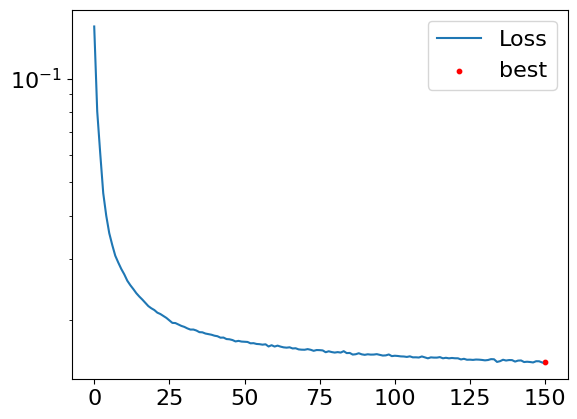

In [27]:
plt.plot(info_losses,label='Loss')
plt.scatter(epoch_best,loss_best,s=10,c='r',label='best')
plt.yscale('log')
plt.legend();

# Post Training: load the best model

In [22]:
import os
import shutil
path = os.getcwd()

In [23]:
options = ocp.CheckpointManagerOptions(
    read_only=True,
    create=False,
)
ckpt_dir = f"{path}/uncondDenMNIST"

mngr = ocp.CheckpointManager(
    ckpt_dir,
    options=options,
)


In [26]:
# Here there is a trick point about orbax that may force you to pratice a hack
# 1) play the following code
# 2) if error, then comment the first line "tate_restored = " and decomment the second one, and play the code
# 3) if error, then return to the first point 1) 'ie first line "tate_restored = " decommented and the second one commented,
#   and play the code. It may happen that the model is fainaly loaded :)


abstract_model = nnx.eval_shape(lambda: Denoiser(rngs=nnx.Rngs(args['seed'])))
graphdef, abstract_state = nnx.split(abstract_model)

epoch_best= mngr.latest_step()
state_restored = mngr.restore(epoch_best, items=abstract_state)
#state_restored = mngr.restore(epoch_best,  args=ocp.args.StandardSave(abstract_state)) # ocp 0.6.4

/usr/local/lib/python3.11/dist-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [27]:
model = nnx.merge(graphdef, state_restored)
model.eval()

# Some tests of the denoiser
How the denoiser denoise?

In [28]:
!ls

data  sample_data  uncondDenMNIST


In [29]:
#dataset_test = datasets.MNIST(os.environ['DSDIR'], train=False, download=False,
#                        transform=transforms.ToTensor())
dataset_test = datasets.MNIST(f'{path}/data', train=False, download=True,
                        transform=transforms.ToTensor())

In [30]:
testloader = torch.utils.data.DataLoader(dataset_test, batch_size=10,
                                          shuffle=True, num_workers=0)


In [31]:
it = iter(testloader)
data,_ = next(it)

In [32]:
data = jnp.array(data.permute(0, 2, 3, 1).numpy())

In [33]:
key = jax.random.PRNGKey(0)

In [34]:
std = 0.5  # remind the image pixel range is [0,1]
key, key_noise = jax.random.split(key,2)
noise = jax.random.normal(key_noise, data.shape) * std
noisy = data + noise  #perturbed
output = model(noisy)  # the model lern the noise
#skip mechanism the denoiser learn the noise
denoised = noisy - output

In [35]:
from skimage.metrics import peak_signal_noise_ratio

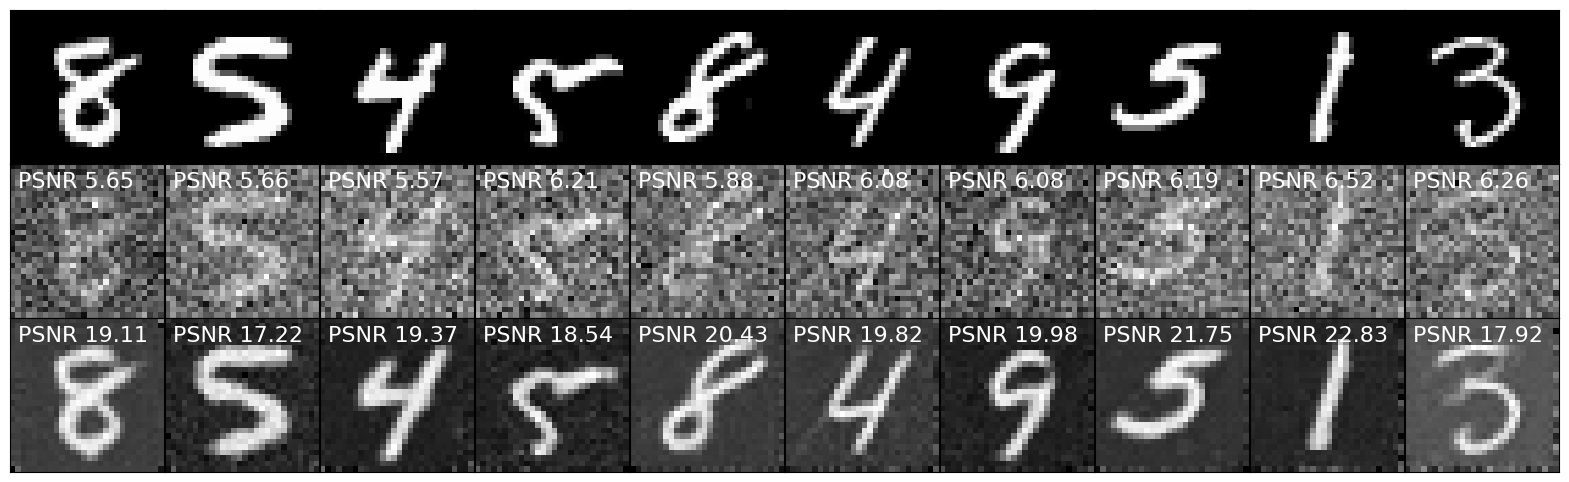

In [36]:
nimg = data.shape[0]
fig, axs = plt.subplots(3,nimg,figsize=(nimg*2,3*2))
for i in range(nimg):
    axs[0,i].imshow(data[i].squeeze(), cmap="gray")
    axs[1,i].imshow(noisy[i].squeeze(), cmap="gray")
    axs[1,i].text(0.05, 0.95, 'PSNR '+ str(round(peak_signal_noise_ratio(noisy[i],data[i],
                  data_range=1),2)),
                  transform=axs[1,i].transAxes, c="white",
                  fontsize=16, va='top', ha='left')
    axs[2,i].imshow(denoised[i].squeeze(), cmap="gray")
    axs[2,i].text(0.05, 0.95, 'PSNR '+ str(round(peak_signal_noise_ratio(denoised[i],data[i],
                  data_range=1),2)),
                  transform=axs[2,i].transAxes, c="white",
                  fontsize=16, va='top', ha='left')

axs = axs.ravel()
for i in range(len(axs)):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)


# Jacobian
This is for advanced studies: you can try to see what are the Top eigenvectors of the adaptive basis (as the ones showed in Figure 3, 4, 5 of reference [2].  "To nalyze inductive biases, we perform a local
analysis of a denoising estimator $\hat{x}(y) = f(y)$ by looking at its Jacobian $\nabla_y f(y)$, and in case of a bias-free denoiser locally $f(y) = \nabla_y f(y) \ y$.

In [48]:
idx = 2
img=data[idx]
img_noisy = noisy[idx]
img_denoised = denoised[idx]

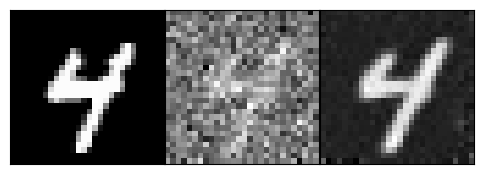

In [49]:
fig,axs = plt.subplots(1,3,figsize=(3*2,2))
axs[0].imshow(img.squeeze(),cmap="gray")
axs[1].imshow(img_noisy.squeeze(),cmap="gray")
axs[2].imshow(img_denoised.squeeze(),cmap="gray")
for i in range(len(axs)):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)


In [50]:
def f(x,i,j):
    return model(x)[i,j,0]

In [51]:
jac = jax.jit(jax.jacfwd(f))

In [52]:
jacob = []
for i in range(img_noisy.shape[0]):
    for j in range(img_noisy.shape[1]):
        res = jac(img_noisy,i,j).flatten()
        jacob.append(res)

In [53]:
J = jnp.array(jacob)

In [54]:
I = jnp.eye(J.shape[0])

In [55]:
U,S, Vh = jnp.linalg.svd(I-J)

In [56]:
V = jnp.transpose(jnp.conjugate(Vh))

In [57]:
V.shape, img_noisy.shape, S.shape

((784, 784), (28, 28, 1), (784,))

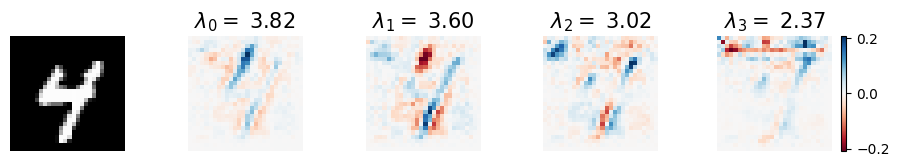

In [58]:
import matplotlib.colors as colors

k = 4
skips = 1
shift = 0
ids = np.concatenate([range(shift,k*skips+shift, skips) ])

f, axs = plt.subplots(1,5, figsize = (5*2,1*2))
plt.tight_layout()
axs = axs.ravel()

axs[0].imshow(img.squeeze(), 'gray')

for i in range(k):
    j = ids[i]
    imlast=axs[i+1].imshow(V[:,j].reshape(img_noisy.shape[0], img_noisy.shape[1]), 'RdBu',norm=colors.CenteredNorm())
    axs[i+1].set_title(f'$\lambda_{j}=$ {S[j]:.2f}' , fontsize = 15)
for i in range(len(axs)):
    axs[i].axis('off');
clb =plt.colorbar(imlast,ax=axs[-1])
clb.ax.tick_params(labelsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.2)

# Sampling
Here we use the code assocaited to the article [1]

## get the map of the mean value of the training image

In [59]:
#dataset_train = datasets.MNIST(os.environ['DSDIR'], train=True, download=False,
#                       transform=transforms.ToTensor())
dataset_train = datasets.MNIST(f'{path}/data', train=True, download=False,
                       transform=transforms.ToTensor())

In [60]:
len(dataset_train)

60000

In [61]:
train_kwargs = {'batch_size': len(dataset_train)}
train_loader = torch.utils.data.DataLoader(dataset_train,**train_kwargs)

In [62]:
itrain = iter(train_loader)
all_data_train,_ = next(itrain)

In [63]:
all_data_train.shape

torch.Size([60000, 1, 28, 28])

In [64]:
all_pixel_mean = all_data_train.mean(dim=0) # shape 1 28, 28

In [65]:
all_pixel_mean = all_pixel_mean.permute(1,2,0)

In [66]:
all_pixel_mean = jnp.array(all_pixel_mean.numpy()) # shape 28,28,1

## sampling algorithm
from Zahra Kadkhodaie &  Eero Peter Simoncelli, *Solving Linear Inverse Problems Using the Prior Implicit in a Denoiser*, NeurIPS 2020 [openreview](https://openreview.net/forum?id=RLN7K4U3UST)

In [67]:
def sampling(key,
             model,
             init_im,          #shape [28,28,1]
             sig_0=1.0,
             sig_L=0.1,
             h0=0.01,
             beta=0.1,
             freq=0,
             init_noise_mean=0.0,
             max_T=10000,
             fixed_h=False,
            debug=False):

  N = init_im.size # number of pixels

  intermed_Ys=[]
  sigmas = []
  means = []

  #init
  y = jnp.expand_dims(init_im,0)  # shape [1, 28, 28, 1]
  if freq > 0:
    intermed_Ys.append(y[0])

  f_y = model(y)
  sigma = jnp.sqrt(jnp.sum(f_y**2))/jnp.sqrt(N)
  sigmas.append(sigma.item())
  means.append(y.mean().item())
  t=1.0

  while sigma > sig_L:  # not jax-like...
    h = h0
    if fixed_h is False:
        h = h0 * t/(1.0 + (h0*(t-1.0)))

    f_y = model(y)
    sigma = jnp.sqrt(jnp.sum(f_y**2))/jnp.sqrt(N)
    sigmas.append(sigma.item())

    gamma = sigma * jnp.sqrt(((1 - (beta * h))**2 - (1.0-h)**2))

    key, subkey = jax.random.split(key)
    noise = jax.random.normal(subkey, shape=init_im.shape)

    if freq > 0 and t%freq == 0 and debug:
        print('-----------------------------', t)
        print('sigma ' , sigma.item() )
        intermed_Ys.append(y[0])

    y = y -  h * f_y + gamma * noise  # was -h*f_y
    means.append(y.mean().item())

    t +=1


    if max_T is not None and t>max_T:
        print('max T surpassed')
        break
    if sigma > 2:
        print('not converging')
        break

  f_y = model(y)  # this is the noise
  denoised_y = y - f_y
  intermed_Ys.append(denoised_y[0])
  sigma = jnp.sqrt(jnp.sum(f_y**2))/jnp.sqrt(N)
  sigmas.append(sigma.item())
  means.append(denoised_y.mean().item())

  return denoised_y, intermed_Ys, sigmas, means

## Show how a sample emerge from the noise

In [68]:
key=jax.random.PRNGKey(1024)
freq=200
sig_0=1.0
key, subkey = jax.random.split(key)
init_im = all_pixel_mean + sig_0 * jax.random.normal(subkey, shape=all_pixel_mean.shape)
denoised_y, intermed_Ys, sigmas, means = sampling(subkey,
                                    model,
                                    init_im,
                                    freq=freq,
                                  fixed_h=True,
                                    debug=True)

----------------------------- 200.0
sigma  0.738571286201477
----------------------------- 400.0
sigma  0.9066550731658936
----------------------------- 600.0
sigma  0.6435798406600952
----------------------------- 800.0
sigma  0.5009036064147949
----------------------------- 1000.0
sigma  0.3160955309867859
----------------------------- 1200.0
sigma  0.2153712660074234
----------------------------- 1400.0
sigma  0.13301822543144226


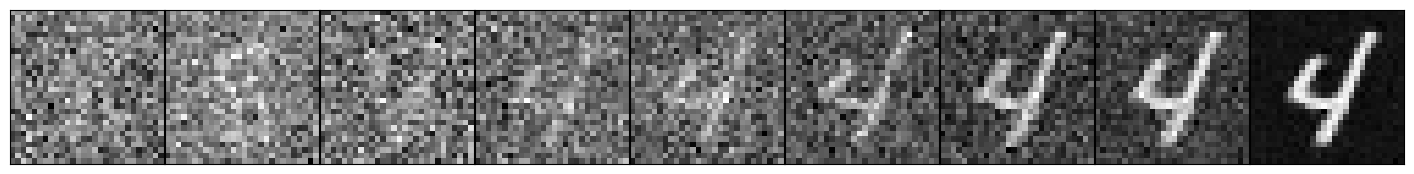

In [69]:
nimg = len(intermed_Ys)
fig, axs = plt.subplots(1,nimg,figsize=(nimg*2,2))
for i in range(nimg):
    axs[i].imshow(intermed_Ys[i].squeeze(), cmap="gray")

axs = axs.ravel()
for i in range(len(axs)):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)


## more samples

In [70]:
#faster generation
def sampling_v2(key,
    model,
    init_im):         #shape [28,28,1):

  N = init_im.size # number of pixels
  sig_0=1.0
  sig_L=0.1
  h0=0.01
  beta=0.1
  max_T=10000

  #init
  y = jnp.expand_dims(init_im,0)  # shape [1, 28, 28, 1]
  f_y = model(y)
  sigma = jnp.sqrt(jnp.sum(f_y**2))/jnp.sqrt(N)
  t=1.0

  val = (key,t,y,sigma)  #while

  def hfun(t, h0):
      return h0 * (t/(1.0 + (h0*(t-1.0))) )

  def body(val):
    key,t,y,sigma = val

    h = hfun(t,h0) # h0 * t/(1.0 + (h0*(t-1.0)))
    f_y = model(y)
    sigma = jnp.sqrt(jnp.sum(f_y**2))/jnp.sqrt(N)

    gamma = sigma * jnp.sqrt(((1 - (beta * h))**2 - (1.0-h)**2))
    key, subkey = jax.random.split(key)
    noise = jax.random.normal(subkey, shape=init_im.shape)
    y = y -  h * f_y + gamma * noise  # was -h*f_y
    t += 1

    return key, t,y,sigma

  def cond(val):
    key,t,y,sigma = val
    return (sigma>0.1) & (sigma<2.0) & (t<max_T)

  val = jax.lax.while_loop(cond,body,val)
  y = val[2]

  f_y = model(y)  # this is the noise
  denoised_y = y - f_y

  return denoised_y

In [71]:
from tqdm.notebook import tqdm

key=jax.random.PRNGKey(1024)
n_samples = 10
sig_0=1.0

all_spls = []
pbar = tqdm(range(1, n_samples+ 1))
for n in pbar:
    key, subkey = jax.random.split(key)
    init_im = all_pixel_mean + sig_0 * jax.random.normal(subkey, shape=all_pixel_mean.shape)
    denoised_y= sampling_v2(subkey,
                        model,
                        init_im)
    all_spls.append(denoised_y[0])


  0%|          | 0/10 [00:00<?, ?it/s]

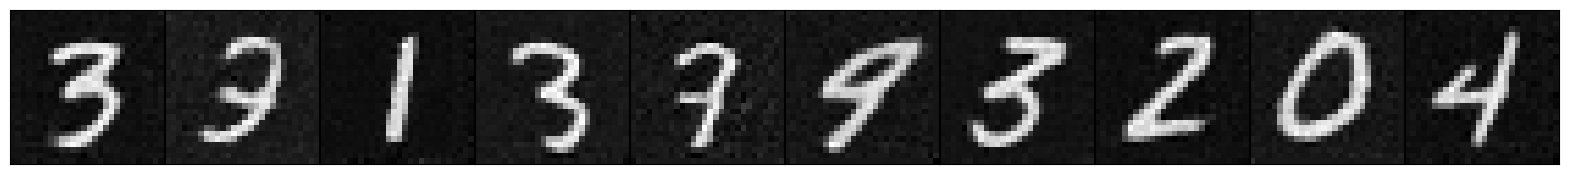

In [73]:
nimg = len(all_spls)
fig, axs = plt.subplots(1,nimg,figsize=(nimg*2,2))
for i in range(nimg):
    axs[i].imshow(all_spls[i].squeeze(), cmap="gray")

axs = axs.ravel()
for i in range(len(axs)):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)


## Similarity Generation-Train
find the closest training image from a generated one: does the mdoel reproduces an image of the training dataset?

In [76]:
all_spls = jnp.array(all_spls)

In [77]:
remove_im_mean = lambda data : data - jnp.mean(data, axis=(1,2,3),keepdims=True)

def jax_null_to_val(x):
    return jnp.where(x==0,0.001,x)

def im_set_corr(set1, set2, remove_mean=True):
    '''
    im_set: tensor of size N,H,W,C
    '''

    if len(set1.shape) != 4 or len(set2.shape) != 4 :
        raise ValueError('Input shape error')
    if remove_mean:
        set1 = remove_im_mean(set1)
        set2 = remove_im_mean(set2)

    norms1 = jnp.linalg.norm(jnp.linalg.norm(set1, axis=(1,2), keepdims=True), axis=3, keepdims=True)
    norms1 = jax_null_to_val(norms1) # to avoid dividing by 0 for blank images
    norms2 = jnp.linalg.norm(jnp.linalg.norm(set2, axis=(1,2), keepdims=True), axis=3, keepdims=True)
    norms2 = jax_null_to_val(norms2) # to avoid dividing by 0 for blank images

    set1 /= norms1
    set2 /= norms2

    set1 = set1.reshape(set1.shape[0],-1)
    set2 = set2.reshape(set2.shape[0],-1)

    return jnp.matmul(set1,set2.T)



In [78]:
all_spls.shape

(10, 28, 28, 1)

In [79]:
all_data_train = all_data_train.permute(0,2,3,1)

In [80]:
all_data_train = jnp.array(all_data_train.numpy())

In [81]:
corrs = im_set_corr(all_spls,  all_data_train)

In [82]:
corrs.shape # 10, 60000

(10, 60000)

In [83]:
def max_val_index(x, axis=0):
    return jnp.max(x,axis=axis),jnp.argmax(x,axis=axis)

In [84]:
values, indices = max_val_index(corrs,axis=1)

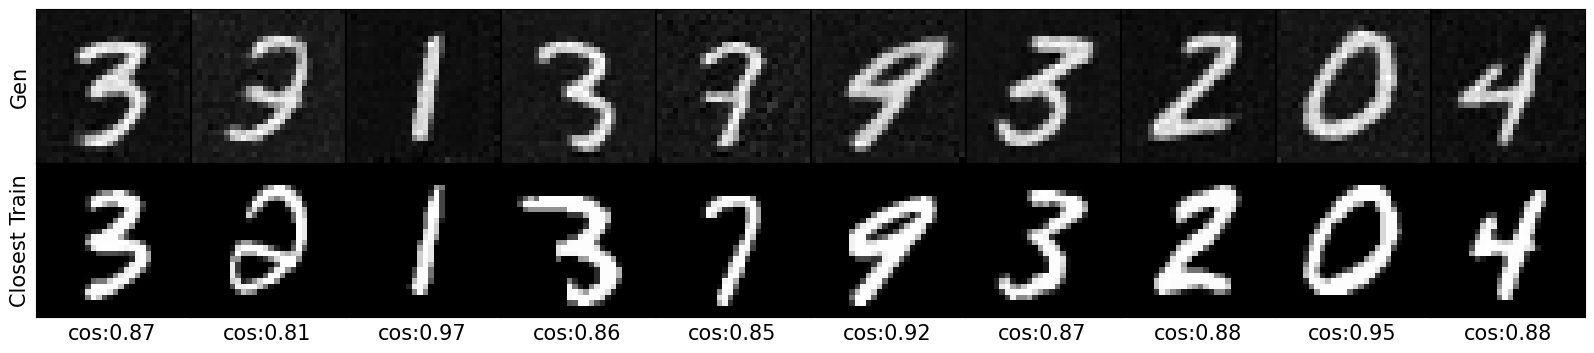

In [85]:
nimg = len(all_spls)
fig, axs = plt.subplots(2,nimg,figsize=(nimg*2,2*2))
for i in range(nimg):
    axs[0,i].imshow(all_spls[i].squeeze(), cmap="gray")
    axs[1,i].imshow(all_data_train[indices[i]].squeeze(), cmap="gray")
    axs[1,i].set_xlabel(f"cos:{values[i]:.2f}",fontsize=15)

axs[0,0].set_ylabel("Gen",fontsize=15)
axs[1,0].set_ylabel("Closest Train",fontsize=15)

axs = axs.ravel()
for i in range(len(axs)):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)
